In [1]:
pip install networkx



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
import matplotlib.pyplot as plt
import ast
from sklearn.manifold import MDS



# load data

In [8]:


# Datei-Pfade
json_file_path = 'data/final/tsp_dataset_with_optimal9.json'  # Ersetze durch den tatsächlichen Pfad der JSON-Datei
predict_then_optimize_file = 'data/final/ML_evaluation_50.csv'  # Ersetze durch den tatsächlichen Pfad der ersten CSV-Datei
predict_and_optimize_file = 'data/final/CO_ML_evaluation_50.csv'    # Ersetze durch den tatsächlichen Pfad der zweiten CSV-Datei

# JSON-Datei laden
try:
    with open(json_file_path, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    print("JSON-Daten geladen:")
    print(json.dumps(json_data, indent=4))  # Schöne Darstellung der JSON-Daten
except Exception as e:
    print(f"Fehler beim Laden der JSON-Datei: {e}")

# CSV-Dateien laden
try:
    predict_then_optimize_data = pd.read_csv(predict_then_optimize_file)
    predict_and_optimize_data = pd.read_csv(predict_and_optimize_file)

    print("\nInhalt der Predict-then-Optimize Datei:")
    print(predict_then_optimize_data.head())  # Nur die ersten Zeilen anzeigen

    print("\nInhalt der Predict-and-Optimize Datei:")
    print(predict_and_optimize_data.head())  # Nur die ersten Zeilen anzeigen
except Exception as e:
    print(f"Fehler beim Laden der CSV-Dateien: {e}")


JSON-Daten geladen:
[
    {
        "nodes": {
            "0": {
                "x": 81.03302561097088,
                "y": 48.98754169612942
            },
            "1": {
                "x": 0.8704354732051778,
                "y": 16.458487199177462
            },
            "2": {
                "x": 52.88438223091349,
                "y": 85.00191831003741
            },
            "3": {
                "x": 1.836715689863666,
                "y": 13.438372124872133
            },
            "4": {
                "x": 77.45424925323263,
                "y": 44.10293570313949
            },
            "5": {
                "x": 76.24715674876383,
                "y": 81.14387306323678
            },
            "6": {
                "x": 28.52063140455474,
                "y": 6.7463388697092785
            },
            "7": {
                "x": 97.11612594154045,
                "y": 87.61632687978042
            },
            "8": {
                "x": 87.45

In [9]:


# JSON-Daten als DataFrame vorbereiten (Nummerierung beginnt bei 1)
json_graphs = []
for index, graph in enumerate(json_data, start=1):  # Start bei 1
    json_graphs.append({
        "Graph ID": index,
        "Koordinaten": graph.get("nodes", {}),
        "True Cost Matrix": graph.get("cost_matrix", []),
        "Optimal Tour": graph.get("optimal_tour", []),
        "Optimal Cost (JSON)": graph.get("total_cost", None)  # Sicherstellen, dass Total Cost existiert
    })
json_df = pd.DataFrame(json_graphs)

# CSV-Dateien laden
pto_df = pd.read_csv(predict_then_optimize_file)
po_df = pd.read_csv(predict_and_optimize_file)

# Spalten umbenennen und True Costs runden
pto_df = pto_df.rename(columns={
    "GraphID": "Graph ID",
    "OptimalTour": "Optimal Tour (PTO)",
    "PredictedTour": "Predicted Tour (PTO)",
    "TrueCost": "Optimal Cost (PTO)",
    "PredictedCost": "Predicted Cost (PTO)",
    "Difference": "Predicted Cost Difference (PTO)"
})
po_df = po_df.rename(columns={
    "Datapoint": "Graph ID",
    "OptimalTour": "Optimal Tour (P&O)",
    "PredictedTour": "Predicted Tour (P&O)",
    "TrueCost": "Optimal Cost (P&O)",
    "PredictedCost": "Predicted Cost (P&O)",
    "CostDifference": "Predicted Cost Difference (P&O)"
})

# True Costs auf eine Nachkommastelle runden
pto_df["Optimal Cost (PTO)"] = pto_df["Optimal Cost (PTO)"].round(1)
po_df["Optimal Cost (P&O)"] = po_df["Optimal Cost (P&O)"].round(1)

# Join der Tabellen
merged_df = json_df.merge(pto_df, on="Graph ID", how="left").merge(po_df, on="Graph ID", how="left")

# Spaltenauswahl
final_columns = [
    "Graph ID", "Koordinaten", "True Cost Matrix", "Optimal Tour", "Optimal Cost (JSON)",
    "Optimal Tour (PTO)", "Predicted Tour (PTO)", "Optimal Cost (PTO)", "Predicted Cost (PTO)",
    "Predicted Cost Difference (PTO)", "Optimal Tour (P&O)", "Predicted Tour (P&O)",
    "Optimal Cost (P&O)", "Predicted Cost (P&O)", "Predicted Cost Difference (P&O)"
]
final_df = merged_df[final_columns]

# Erfolgsprüfung: Vergleich der Optimal Costs
final_df.loc[:, "Optimal Cost Match (PTO)"] = final_df["Optimal Cost (JSON)"].round(1) == final_df["Optimal Cost (PTO)"]
final_df.loc[:, "Optimal Cost Match (P&O)"] = final_df["Optimal Cost (JSON)"].round(1) == final_df["Optimal Cost (P&O)"]


# Erfolgsmeldung
pto_matches = final_df["Optimal Cost Match (PTO)"].sum()
po_matches = final_df["Optimal Cost Match (P&O)"].sum()
print(f"Number of correct PTO matches: {pto_matches}")
print(f"Number of correct P&O matches: {po_matches}")

# Reduzierte Spaltenauswahl nach der Prüfung
reduced_columns = [
    "Graph ID", "Koordinaten", "True Cost Matrix", "Optimal Tour", "Optimal Cost (JSON)",
    "Predicted Tour (PTO)", "Predicted Cost (PTO)","Predicted Cost Difference (PTO)",  
    "Predicted Tour (P&O)", "Predicted Cost (P&O)", "Predicted Cost Difference (P&O)"
]

# Entfernen der redundanten Spalten
final_df = final_df[reduced_columns]

# Erfolgsmeldung basierend auf der Prüfung
print("Prüfung abgeschlossen:")
print(f"Die Anzahl korrekter PTO-Einträge beträgt: {pto_matches}")
print(f"Die Anzahl korrekter P&O-Einträge beträgt: {po_matches}")
print(f"Die reduzierte Tabelle enthält {len(final_df.columns)} Spalten.")

# Zeige die ersten Zeilen der bereinigten Tabelle
print(final_df.head())



Number of correct PTO matches: 50
Number of correct P&O matches: 50
Prüfung abgeschlossen:
Die Anzahl korrekter PTO-Einträge beträgt: 50
Die Anzahl korrekter P&O-Einträge beträgt: 50
Die reduzierte Tabelle enthält 11 Spalten.
   Graph ID                                        Koordinaten  \
0         1  {'0': {'x': 81.03302561097088, 'y': 48.9875416...   
1         2  {'0': {'x': 28.969452449369292, 'y': 11.972933...   
2         3  {'0': {'x': 93.05499163931296, 'y': 28.4248958...   
3         4  {'0': {'x': 91.88857675803031, 'y': 56.4709483...   
4         5  {'0': {'x': 49.241093108343705, 'y': 50.040873...   

                                    True Cost Matrix  \
0  [[inf, 16.8, 13.900000000000002, 14.0, 15.0, 1...   
1  [[inf, 20.299999999999997, 15.099999999999998,...   
2  [[inf, 12.0, 13.999999999999998, 17.8, 10.4, 1...   
3  [[inf, 15.4, 19.9, 14.800000000000002, 10.4, 8...   
4  [[inf, 19.3, 11.5, 19.1, 16.200000000000003, 1...   

                                        

/var/folders/h7/gffk63ks66s4x_r7sz_63r9h0000gn/T/ipykernel_3943/1805257655.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.loc[:, "Optimal Cost Match (PTO)"] = final_df["Optimal Cost (JSON)"].round(1) == final_df["Optimal Cost (PTO)"]
/var/folders/h7/gffk63ks66s4x_r7sz_63r9h0000gn/T/ipykernel_3943/1805257655.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.loc[:, "Optimal Cost Match (P&O)"] = final_df["Optimal Cost (JSON)"].round(1) == final_df["Optimal Cost (P&O)"]


In [10]:
# Zeige alle Spaltennamen im final_df an
print("Spalten im DataFrame:", final_df.columns.tolist())


Spalten im DataFrame: ['Graph ID', 'Koordinaten', 'True Cost Matrix', 'Optimal Tour', 'Optimal Cost (JSON)', 'Predicted Tour (PTO)', 'Predicted Cost (PTO)', 'Predicted Cost Difference (PTO)', 'Predicted Tour (P&O)', 'Predicted Cost (P&O)', 'Predicted Cost Difference (P&O)']


In [13]:


df = final_df
# Compute Differences
df['DiffPTO'] = abs(df['Predicted Cost (PTO)'] - df['Optimal Cost (JSON)'])
df['DiffP&O'] = abs(df['Predicted Cost (P&O)'] - df['Optimal Cost (JSON)'])

# Compute Relative Loss for each model (if not already calculated)
df['Relative Loss (PTO)'] = (df['Predicted Cost (PTO)'] - df['Optimal Cost (JSON)']) / df['Optimal Cost (JSON)']
df['Relative Loss (P&O)'] = (df['Predicted Cost (P&O)'] - df['Optimal Cost (JSON)']) / df['Optimal Cost (JSON)']

# Compute the average relative loss for each model
avg_relative_loss_pto = df['Relative Loss (PTO)'].mean()
avg_relative_loss_pno = df['Relative Loss (P&O)'].mean()

# Compute the overall relative loss ratio
overall_relative_loss_ratio = avg_relative_loss_pno / avg_relative_loss_pto

# Print results
print(f"Average Relative Loss (PTO): {avg_relative_loss_pto:.4f}")
print(f"Average Relative Loss (P&O): {avg_relative_loss_pno:.4f}")
print(f"Overall Relative Loss Ratio (P&O / PTO): {overall_relative_loss_ratio:.4f}")

# Interpret the results
if overall_relative_loss_ratio > 1:
    print("P&O performs worse on average.")
elif overall_relative_loss_ratio < 1:
    print("PTO performs worse on average.")
else:
    print("Both models perform equally on average.")





Average Relative Loss (PTO): 0.4563
Average Relative Loss (P&O): 0.4441
Overall Relative Loss Ratio (P&O / PTO): 0.9734
PTO performs worse on average.


# plot the data

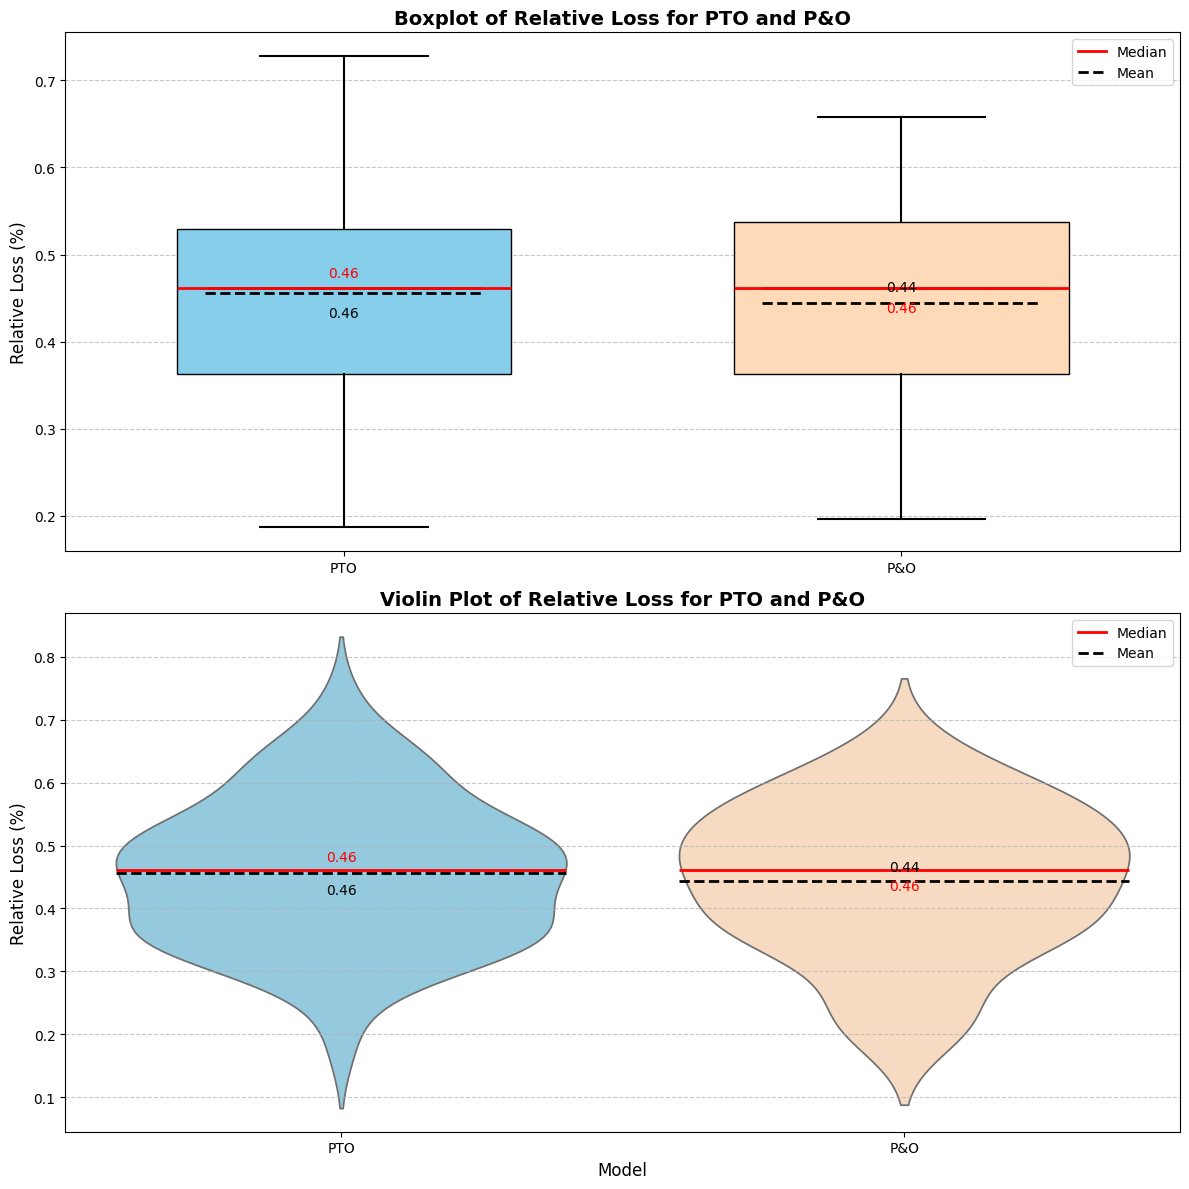

In [14]:

# Simulated data (replace with actual data)
data_pto = df['Relative Loss (PTO)']  # Replace with actual column
data_pno = df['Relative Loss (P&O)']  # Replace with actual column

# Combine data into a list
data = [data_pto, data_pno]
labels = ['PTO', 'P&O']  # Correct x-axis labels

# Define distinct colors for the models
colors = ['skyblue', 'peachpuff']  # Colors for PTO and P&O

# Calculate statistics
def get_stats(data):
    stats = {
        "min": np.min(data),
        "max": np.max(data),
        "mean": np.mean(data),
        "median": np.median(data),
        "q1": np.percentile(data, 25),
        "q3": np.percentile(data, 75),
        "iqr": np.percentile(data, 75) - np.percentile(data, 25),
        "outliers": data[(data < np.percentile(data, 25) - 1.5 * (np.percentile(data, 75) - np.percentile(data, 25))) |
                         (data > np.percentile(data, 75) + 1.5 * (np.percentile(data, 75) - np.percentile(data, 25)))]
    }
    return stats

# Calculate statistics for both datasets
stats_pto = get_stats(data_pto)
stats_pno = get_stats(data_pno)

# Create a figure with two independent subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Plot 1: Boxplot
boxprops = dict(linewidth=1.5)
for i, (data_item, color) in enumerate(zip(data, colors)):
    # Create individual boxplots for distinct colors
    axs[0].boxplot([data_item], positions=[i + 1], widths=0.6, patch_artist=True,
                   boxprops=dict(facecolor=color, edgecolor='black'),
                   medianprops=dict(color='red', linewidth=2),
                   whiskerprops=dict(color='black', linewidth=1.5),
                   capprops=dict(color='black', linewidth=1.5))

# Add median and mean annotations for the boxplot
for i, (stats, color) in enumerate(zip([stats_pto, stats_pno], colors)):
    if i == 1:  # Switch for P&O (right side)
        # Mean (positioned above)
        axs[0].text(i + 1, stats['mean'] + 0.01, f"{stats['mean']:.2f}", ha='center', va='bottom', fontsize=10, color='black')
        axs[0].hlines(stats['mean'], i + 0.75, i + 1.25, colors='black', linestyles='--', linewidth=2)
        # Median (positioned below)
        axs[0].text(i + 1, stats['median'] - 0.015, f"{stats['median']:.2f}", ha='center', va='top', fontsize=10, color='red')
        axs[0].hlines(stats['median'], i + 0.75, i + 1.25, colors='red', linestyles='-', linewidth=2)
    else:  # Default for PTO (left side)
        # Median (positioned above)
        axs[0].text(i + 1, stats['median'] + 0.01, f"{stats['median']:.2f}", ha='center', va='bottom', fontsize=10, color='red')
        axs[0].hlines(stats['median'], i + 0.75, i + 1.25, colors='red', linestyles='-', linewidth=2)
        # Mean (positioned below)
        axs[0].text(i + 1, stats['mean'] - 0.015, f"{stats['mean']:.2f}", ha='center', va='top', fontsize=10, color='black')
        axs[0].hlines(stats['mean'], i + 0.75, i + 1.25, colors='black', linestyles='--', linewidth=2)

# Add correct x-axis labels to the boxplot
axs[0].set_xticks([1, 2])  # Set x-tick positions
axs[0].set_xticklabels(labels)  # Set x-tick labels

# Add title and labels for the boxplot
axs[0].set_title('Boxplot of Relative Loss for PTO and P&O', fontsize=14, weight='bold')
axs[0].set_ylabel('Relative Loss (%)', fontsize=12)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Violin Plot
sns.violinplot(data=data, ax=axs[1], inner=None, palette=colors)

# Add median and mean lines to the violin plot
for i, stats in enumerate([stats_pto, stats_pno]):
    if i == 1:  # Switch for P&O (right side)
        # Mean (positioned above)
        axs[1].hlines(stats['mean'], i - 0.4, i + 0.4, colors='black', linestyles='--', linewidth=2)
        axs[1].text(i, stats['mean'] + 0.01, f"{stats['mean']:.2f}", ha='center', va='bottom', fontsize=10, color='black')
        # Median (positioned below)
        axs[1].hlines(stats['median'], i - 0.4, i + 0.4, colors='red', linestyles='-', linewidth=2)
        axs[1].text(i, stats['median'] - 0.015, f"{stats['median']:.2f}", ha='center', va='top', fontsize=10, color='red')
    else:  # Default for PTO (left side)
        # Median (positioned above)
        axs[1].hlines(stats['median'], i - 0.4, i + 0.4, colors='red', linestyles='-', linewidth=2)
        axs[1].text(i, stats['median'] + 0.01, f"{stats['median']:.2f}", ha='center', va='bottom', fontsize=10, color='red')
        # Mean (positioned below)
        axs[1].hlines(stats['mean'], i - 0.4, i + 0.4, colors='black', linestyles='--', linewidth=2)
        axs[1].text(i, stats['mean'] - 0.015, f"{stats['mean']:.2f}", ha='center', va='top', fontsize=10, color='black')

# Add title and labels for the violin plot
axs[1].set_title('Violin Plot of Relative Loss for PTO and P&O', fontsize=14, weight='bold')
axs[1].set_ylabel('Relative Loss (%)', fontsize=12)
axs[1].set_xlabel('Model', fontsize=12)
axs[1].set_xticks([0, 1])  # Set x-tick positions for violin plot
axs[1].set_xticklabels(labels)  # Set x-tick labels for violin plot
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add legends to explain color coding
red_patch = plt.Line2D([0], [0], color='red', linewidth=2, label='Median')
black_patch = plt.Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='Mean')
axs[0].legend(handles=[red_patch, black_patch], loc='upper right', fontsize=10)
axs[1].legend(handles=[red_patch, black_patch], loc='upper right', fontsize=10)

# Adjust layout for readability
plt.tight_layout()
plt.show()


In [ ]:
plt.savefig('/Users/jakobmayer/Desktop/VSCode/refined_loss_differences_boxplot_with_highlighted_lines.png')

In [15]:
# Print the types and first few entries of the relevant columns
print("Data types of columns in df:")
print(df.dtypes)

# Print the first few rows for the relevant columns
columns_to_check = [
    'Predicted Cost Difference (PTO)', 
    'Predicted Cost Difference (P&O)', 
    'Optimal Cost (JSON)', 
    'True Cost Matrix', 
    'Predicted Tour (PTO)', 
    'Optimal Tour'
]

print("\nSample data for the relevant columns:")
print(df[columns_to_check].head())

# Optionally print individual column types and first few values for detailed inspection
for column in columns_to_check:
    print(f"\nColumn: {column}")
    print(f"Type: {df[column].dtype}")
    print(f"First few values:\n{df[column].head()}")


Data types of columns in df:
Graph ID                             int64
Koordinaten                         object
True Cost Matrix                    object
Optimal Tour                        object
Optimal Cost (JSON)                float64
Predicted Tour (PTO)                object
Predicted Cost (PTO)               float64
Predicted Cost Difference (PTO)    float64
Predicted Tour (P&O)                object
Predicted Cost (P&O)               float64
Predicted Cost Difference (P&O)    float64
DiffPTO                            float64
DiffP&O                            float64
Relative Loss (PTO)                float64
Relative Loss (P&O)                float64
dtype: object

Sample data for the relevant columns:
   Predicted Cost Difference (PTO)  Predicted Cost Difference (P&O)  \
0                        35.499995                        39.400004   
1                        52.900015                        42.500006   
2                        43.099997                        39

# plot the tour change the tour by changing the id variable

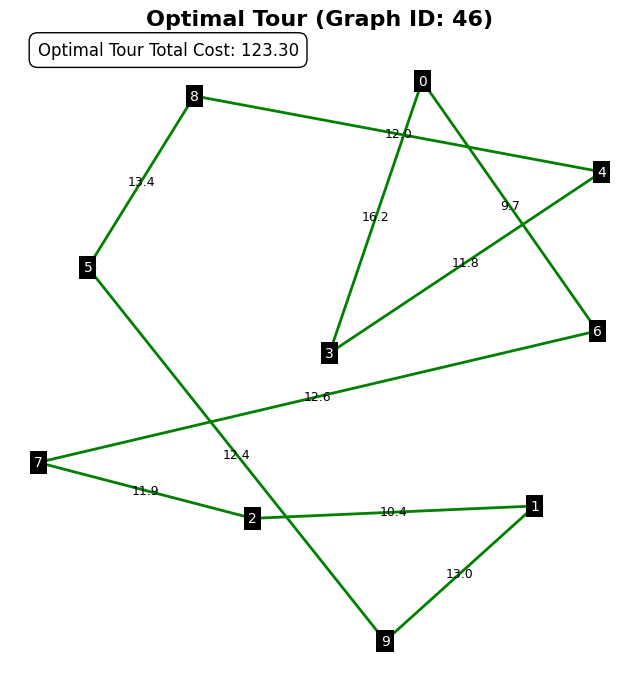

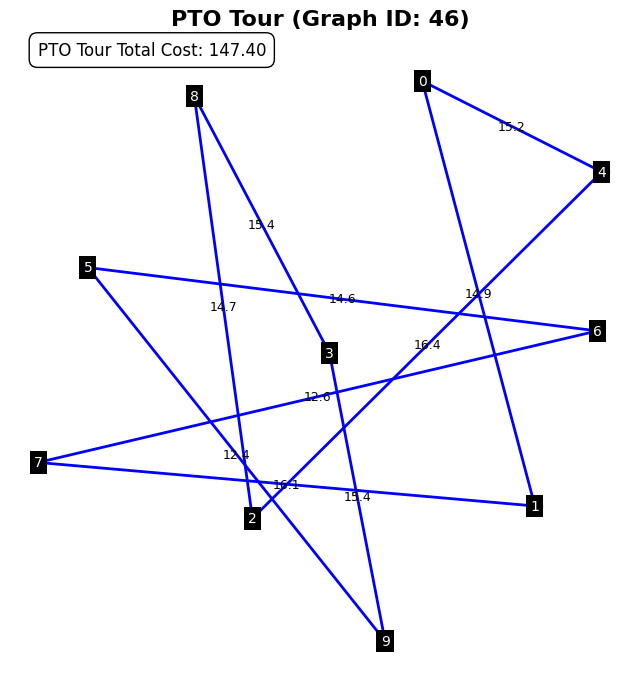

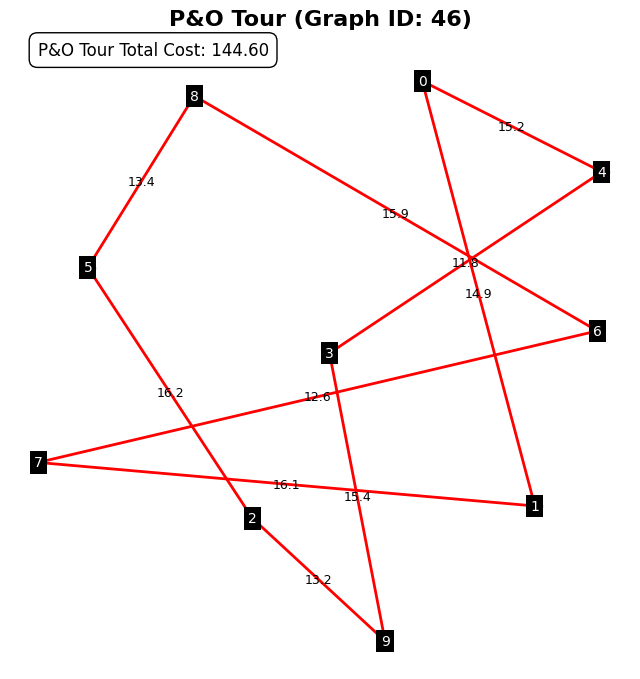

In [16]:


# Parse the cost matrix
def parse_cost_matrix(cost_matrix_input):
    if isinstance(cost_matrix_input, str):
        cost_matrix_input = ast.literal_eval(cost_matrix_input)
    cost_matrix = np.array(cost_matrix_input)
    
    # Ensure the matrix is symmetric
    cost_matrix = (cost_matrix + cost_matrix.T) / 2
    
    # Fill diagonal with 0s
    np.fill_diagonal(cost_matrix, 0)
    
    return cost_matrix

# Parse the tour input into a list of edges
def parse_tour(tour_input):
    if isinstance(tour_input, str):
        tour_input = tour_input.replace("->", ",").replace("(", "[").replace(")", "]")
        return [tuple(edge) for edge in ast.literal_eval(tour_input)]
    elif isinstance(tour_input, list):
        return [tuple(edge) for edge in tour_input]
    else:
        raise ValueError(f"Unexpected tour format: {tour_input}")

# Normalize tour indices to 0-based indexing
def normalize_tour_indices(tour):
    min_index = min(min(start, end) for start, end in tour)
    if min_index == 1:  # Convert 1-based to 0-based
        return [(start - 1, end - 1) for start, end in tour]
    return tour

# Perform MDS to get node coordinates
def compute_mds_coordinates(cost_matrix, n_components=2):
    mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(cost_matrix)
    return {i: (coord[0], coord[1]) for i, coord in enumerate(coords)}

# Calculate total tour cost
def calculate_tour_cost(tour, cost_matrix):
    total_cost = sum(cost_matrix[start, end] for start, end in tour)
    return total_cost

# Plot a single tour
def plot_single_tour(node_coords, tour, total_cost, cost_matrix, title, color='green', label="Tour"):
    plt.figure(figsize=(8, 8))

    # Plot nodes
    for node, (x, y) in node_coords.items():
        plt.scatter(x, y, color='black', s=100, zorder=3)
        plt.text(x, y, str(node), fontsize=10, ha='center', va='center', color='white',
                 bbox=dict(facecolor='black', edgecolor='none', pad=3.0))

    # Plot the edges in the tour
    for start, end in tour:
        x_start, y_start = node_coords[start]
        x_end, y_end = node_coords[end]
        plt.plot([x_start, x_end], [y_start, y_end], color=color, lw=2)
        
        # Add edge costs
        edge_cost = cost_matrix[start, end]
        midpoint = [(x_start + x_end) / 2, (y_start + y_end) / 2]
        plt.text(midpoint[0], midpoint[1], f"{edge_cost:.1f}", fontsize=9, ha="center", va="center", color="black")

    # Add total cost legend at the top left below the title
    plt.text(-10, 11.3, f"{label} Total Cost: {total_cost:.2f}", fontsize=12, ha="left", va="top",
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    # Add title
    plt.title(title, fontsize=16, weight='bold', pad=20)
    plt.axis('off')
    plt.show()

# Main function to process and visualize all tours
def display_tours_separately(graph_id, df):
    try:
        graph_data = df[df['Graph ID'] == graph_id].iloc[0]
    except IndexError:
        print(f"Graph ID {graph_id} not found in the dataset.")
        return

    # Parse data
    cost_matrix = parse_cost_matrix(graph_data['True Cost Matrix'])
    optimal_tour = normalize_tour_indices(parse_tour(graph_data['Optimal Tour']))
    pto_tour = normalize_tour_indices(parse_tour(graph_data['Predicted Tour (PTO)']))
    po_tour = normalize_tour_indices(parse_tour(graph_data['Predicted Tour (P&O)']))

    # Perform MDS to compute node coordinates
    node_coords = compute_mds_coordinates(cost_matrix)

    # Calculate total costs
    optimal_cost = calculate_tour_cost(optimal_tour, cost_matrix)
    pto_cost = calculate_tour_cost(pto_tour, cost_matrix)
    po_cost = calculate_tour_cost(po_tour, cost_matrix)

    # Plot Optimal Tour
    plot_single_tour(
        node_coords=node_coords,
        tour=optimal_tour,
        total_cost=optimal_cost,
        cost_matrix=cost_matrix,
        title=f"Optimal Tour (Graph ID: {graph_id})",
        color='green',
        label="Optimal Tour"
    )

    # Plot PTO Tour
    plot_single_tour(
        node_coords=node_coords,
        tour=pto_tour,
        total_cost=pto_cost,
        cost_matrix=cost_matrix,
        title=f"PTO Tour (Graph ID: {graph_id})",
        color='blue',
        label="PTO Tour"
    )

    # Plot P&O Tour
    plot_single_tour(
        node_coords=node_coords,
        tour=po_tour,
        total_cost=po_cost,
        cost_matrix=cost_matrix,
        title=f"P&O Tour (Graph ID: {graph_id})",
        color='red',
        label="P&O Tour"
    )

# Example usage
# Replace `df` with your actual DataFrame containing the graph data
graph_id = 46  # Specify the graph ID to visualize
display_tours_separately(graph_id, df)
